In [1]:
# Cell 1: Imports and Setup

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
from tqdm import tqdm
import warnings

# Configure plot styles
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
import os

# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    pass  # Skip mounting if not using Colab

# Define full paths directly
raw_path = '709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF'
segmented_path = '709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF_Segmented'

# Dataset parameters
NUM_IMAGES = 887

# Print paths for confirmation
print(f"✅ Raw data path set to: {raw_path}")
print(f"✅ Segmented data path set to: {segmented_path}")

✅ Raw data path set to: 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF
✅ Segmented data path set to: 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF_Segmented


In [3]:
# Cell 3: Image Loading Function

def load_image_stack(folder_path, name_template, num_images):
    """
    Loads a sequence of TIFF images into a 3D NumPy array.

    Args:
        folder_path (str): The path to the directory containing the images.
        name_template (str): A string template for the filenames, using '{i}' as a placeholder
                             for the image number (e.g., "image_Z{i:05d}.tif").
        num_images (int): The total number of images to load.

    Returns:
        np.ndarray: A 3D NumPy array of shape (num_images, height, width).
    """
    image_stack = []
    print(f"Loading {num_images} images from {os.path.basename(folder_path)}...")

    for i in tqdm(range(1, num_images + 1)):
        filename = name_template.format(i=i)
        file_path = os.path.join(folder_path, filename)

        try:
            with Image.open(file_path) as img:
                image_stack.append(np.array(img))
        except FileNotFoundError:
            print(f"Warning: File not found at {file_path}. Skipping.")
            continue

    if not image_stack:
        raise ValueError("No images were loaded. Check paths and filenames.")

    return np.stack(image_stack, axis=0)

# --- Define filename templates based on your `dir` output ---
raw_template = "709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMFZ{i:05d}.tif"
segmented_template = "709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMFZ{i:05d}_Simple Segmentation.tif"


# --- Load the datasets ---
raw_images = load_image_stack(raw_path, raw_template, NUM_IMAGES)
segmented_images = load_image_stack(segmented_path, segmented_template, NUM_IMAGES)

print("\nData loading complete!")

Loading 887 images from 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF...


100%|██████████| 887/887 [00:20<00:00, 43.99it/s]


Loading 887 images from 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF_Segmented...


100%|██████████| 887/887 [00:14<00:00, 59.30it/s]



Data loading complete!


In [4]:
# Cell 4: Basic Data Inspection

def inspect_data(data, name):
    """Prints key properties of the image stack."""
    print(f"--- Inspection for: {name} ---")
    print(f"Shape (Slices, Height, Width): {data.shape}")
    print(f"Data Type: {data.dtype}")
    # Calculate memory in MB
    memory_mb = data.nbytes / (1024 * 1024)
    print(f"Memory Usage: {memory_mb:.2f} MB")
    print(f"Pixel value range: Min={data.min()}, Max={data.max()}\n")

inspect_data(raw_images, "Raw CT Scans")
inspect_data(segmented_images, "Segmented Porosity Maps")

--- Inspection for: Raw CT Scans ---
Shape (Slices, Height, Width): (887, 1024, 996)
Data Type: uint16
Memory Usage: 1725.49 MB
Pixel value range: Min=0, Max=54108

--- Inspection for: Segmented Porosity Maps ---
Shape (Slices, Height, Width): (887, 1024, 996)
Data Type: uint8
Memory Usage: 862.75 MB
Pixel value range: Min=1, Max=2



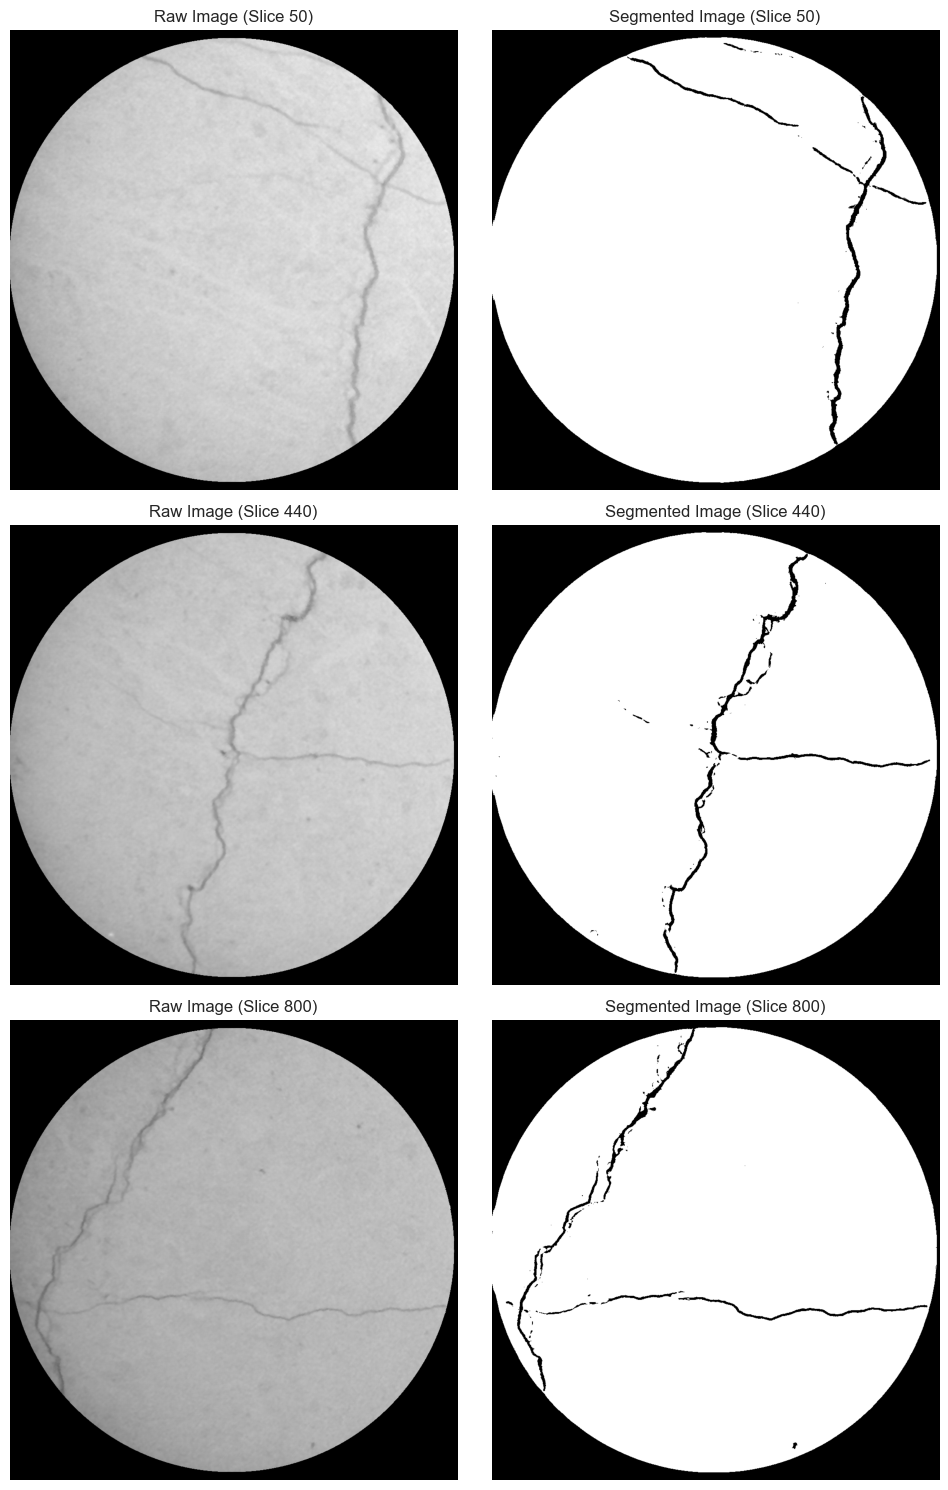

In [5]:
# Cell 5: Visualize 2D Image Slices

def show_slices(raw_stack, segmented_stack, slice_indices):
    """Displays corresponding raw and segmented slices side-by-side."""
    num_slices = len(slice_indices)
    fig, axes = plt.subplots(num_slices, 2, figsize=(10, 5 * num_slices))

    # Adjust for single slice case
    if num_slices == 1:
        axes = np.array([axes])

    for i, slice_idx in enumerate(slice_indices):
        # Raw Image
        axes[i, 0].imshow(raw_stack[slice_idx], cmap='gray')
        axes[i, 0].set_title(f'Raw Image (Slice {slice_idx})')
        axes[i, 0].axis('off')

        # Segmented Image
        axes[i, 1].imshow(segmented_stack[slice_idx], cmap='gray')
        axes[i, 1].set_title(f'Segmented Image (Slice {slice_idx})')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# --- Select some slices to display (e.g., start, middle, end) ---
slices_to_show = [50, 440, 800]
show_slices(raw_images, segmented_images, slices_to_show)

Overall Average Porosity (Φ): 0.2542 or 25.42%


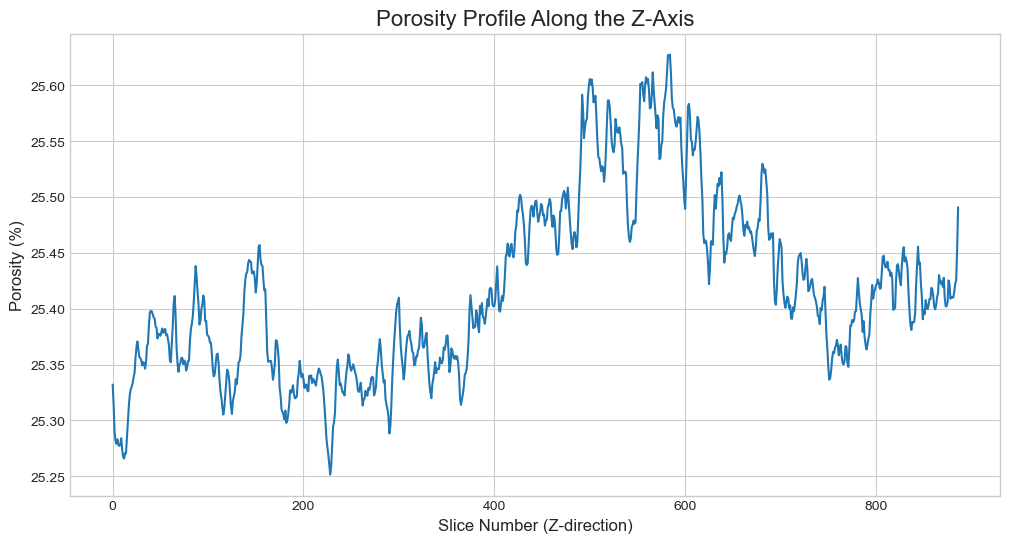

In [6]:
# Cell 6: Calculate and Plot Porosity

# Assuming pores are represented by non-zero pixels in the segmented images.
# If pores are 0, use `segmented_images == 0`.
total_pixels_per_slice = segmented_images.shape[1] * segmented_images.shape[2]
pore_pixels_per_slice = np.sum(segmented_images == 1 , axis=(1, 2))

# Calculate porosity for each slice
porosity_per_slice = pore_pixels_per_slice / total_pixels_per_slice

# Calculate the overall average porosity
overall_porosity = np.mean(porosity_per_slice)

print(f"Overall Average Porosity (Φ): {overall_porosity:.4f} or {overall_porosity*100:.2f}%")

# --- Plot porosity vs. Z-slice ---
plt.figure(figsize=(12, 6))
plt.plot(range(NUM_IMAGES), porosity_per_slice * 100)
plt.title('Porosity Profile Along the Z-Axis', fontsize=16)
plt.xlabel('Slice Number (Z-direction)', fontsize=12)
plt.ylabel('Porosity (%)', fontsize=12)
plt.grid(True)
plt.show()

Slice 443 Pixel Distribution:
  Value 1: 260038 pixels (25.50%)
  Value 2: 759866 pixels (74.50%)


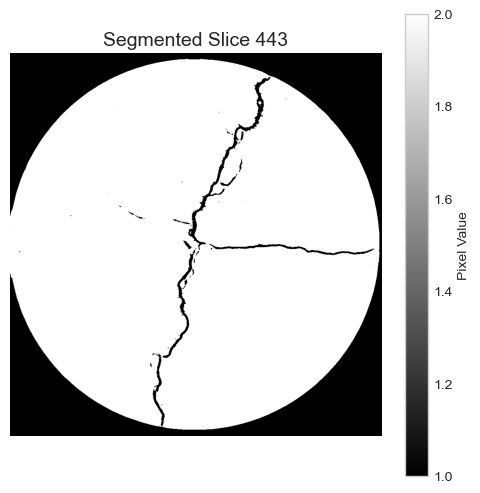

In [7]:
# Choose a slice index to inspect (e.g., middle slice)
slice_index = NUM_IMAGES // 2
slice_image = segmented_images[slice_index]

# Count pixel values
unique, counts = np.unique(slice_image, return_counts=True)
pixel_stats = dict(zip(unique, counts))

# Total pixels in the slice
total_pixels = slice_image.size

# Print pixel distribution and percentages
print(f"Slice {slice_index} Pixel Distribution:")
for value, count in pixel_stats.items():
    percentage = (count / total_pixels) * 100
    print(f"  Value {value}: {count} pixels ({percentage:.2f}%)")

# --- Visualize the slice ---
plt.figure(figsize=(6, 6))
plt.imshow(slice_image, cmap='gray')
plt.title(f'Segmented Slice {slice_index}', fontsize=14)
plt.axis('off')
plt.colorbar(label='Pixel Value')
plt.show()

Preparing 3D visualization... This may take a moment.


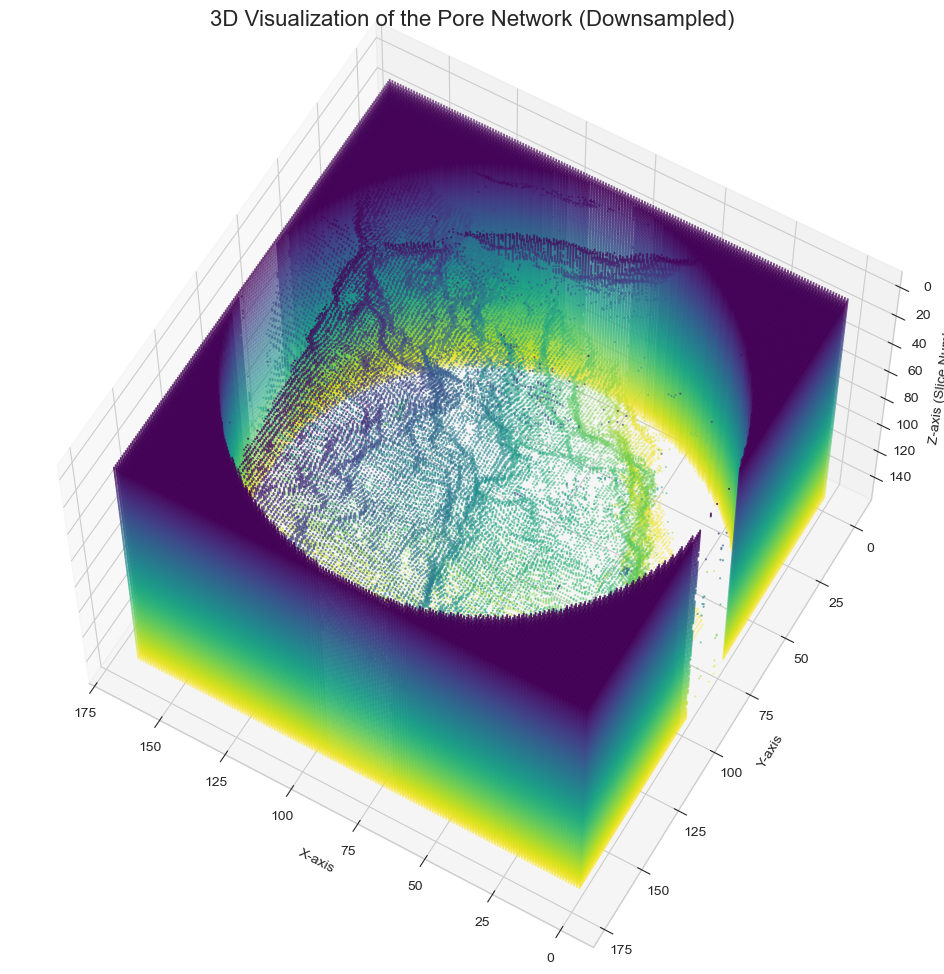

In [8]:
# Cell 7: 3D Visualization of Pore Space

print("Preparing 3D visualization... This may take a moment.")

# --- Downsample the data to make plotting feasible ---
# A factor of 4 means we take every 4th pixel in each dimension.
# Adjust this factor based on your system's performance.
downsample_factor = 6
segmented_downsampled = segmented_images[::downsample_factor, ::downsample_factor, ::downsample_factor]

# Get the coordinates of the pore pixels (where pixel value > 0)
z, y, x = np.where(segmented_downsampled == 1)

# --- Create the 3D Scatter Plot ---
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot the pore coordinates
ax.scatter(x, y, z, s=1, c=z, cmap='viridis', marker='.')

ax.set_title('3D Visualization of the Pore Network (Downsampled)', fontsize=16)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis (Slice Number)')

# Invert Z-axis so slice 0 is at the top, like a stack
ax.invert_zaxis()
ax.view_init(elev=60, azim=120)

plt.show()

In [20]:
pip install Vedo

Note: you may need to restart the kernel to use updated packages.


In [9]:
from vedo import Volume, show, Plotter
import numpy as np

# Create volume from segmented images
pore_volume = Volume(segmented_images)

# Define threshold value for isosurface
threshold_value = np.mean(segmented_images)

# Generate isosurface mesh and apply visual properties
pore_mesh = (
    pore_volume.isosurface(threshold_value)
    .c('cyan')
    .opacity(0.8)
    .lighting('plastic')           # Apply lighting model
)

# Create Plotter in offscreen mode
plotter = Plotter(offscreen=True)

# Add mesh and render
plotter.show(pore_mesh, axes=1, viewup='z', interactive=False)

# Save screenshot
plotter.screenshot("pore_network.png")

# Close the plotter
plotter.close()

In [10]:
from vedo import Volume, show, Plotter, settings
import numpy as np

# Optional: improve rendering quality
settings.use_depth_peeling = True

# --- Step 1: Preprocess segmented volume ---
segmented_images = segmented_images.astype(np.float32)
segmented_images /= segmented_images.max()  # Normalize to [0, 1]

# --- Step 2: Create vedo Volume object ---
pore_volume = Volume(segmented_images)

# --- Step 3: Choose threshold for isosurface ---
threshold_value = np.percentile(segmented_images, 30)  # Adjust percentile to capture pores

# --- Step 4: Generate isosurface mesh ---
pore_mesh = (
    pore_volume.isosurface(threshold_value)
    .c('lightblue')               # Color
    .opacity(0.6)                 # Transparency
    .lighting('plastic')         # Lighting model
    .smooth(niter=15)             # Optional smoothing
)

# --- Step 5: Optional volume rendering overlay ---
pore_volume.cmap('bone').alpha([0, 0.1, 0.3, 0.6, 0.8])  # Alpha transfer function

# --- Step 6: Render and save screenshot ---
plotter = Plotter(bg='black', offscreen=True)
plotter.show(pore_volume, pore_mesh, axes=1, viewup='z')
plotter.screenshot("pore_network2.png")

In [4]:
import torch

if torch.cuda.is_available():
    print("✅ CUDA is available. You can use GPU.")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("❌ CUDA is not available. You're using CPU.")

✅ CUDA is available. You can use GPU.
GPU Name: NVIDIA GeForce GTX 1050


In [5]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.9.0.dev20250716+cu129
12.9
True
NVIDIA GeForce GTX 1050


In [7]:
# Cell 9: Data Preparation for GAN (Corrected)

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms.functional import resize, to_tensor, normalize
import torch.nn as nn

# --- Hyperparameters and Setup ---
DEVICE = "cpu"
IMG_SIZE = 256  # Resize images to 256x256
BATCH_SIZE = 4    # Adjust based on your GPU memory
LEARNING_RATE = 2e-4
BETA1 = 0.5
L1_LAMBDA = 100 # Weight for the L1 reconstruction loss

print(f"Using device: {DEVICE}")

# --- Create Solid Rock Images (Inputs) ---
# We'll fill the pores with the average value of the surrounding rock
rock_value = np.median(raw_images[segmented_images == 0])
solid_rock_images = np.where(segmented_images > 0, rock_value, raw_images)

# --- FIX: Convert both datasets to float32 and scale to [0, 1] ---
# Your data is uint16, so its maximum value is 65535.
# We convert the type to float32 and divide by the max value to scale it.
solid_rock_images_scaled = solid_rock_images.astype(np.float32) / 65535.0
raw_images_scaled = raw_images.astype(np.float32) / 65535.0


# --- Preprocess and Create Tensors ---
# This function now expects a float numpy array scaled between 0 and 1.
def preprocess_stack(stack_scaled):
    processed_tensors = []
    for img in tqdm(stack_scaled, desc="Preprocessing images"):
        # to_tensor converts a float numpy array in [0, 1] to a FloatTensor of the same range.
        img_tensor = to_tensor(img)
        img_resized = resize(img_tensor, [IMG_SIZE, IMG_SIZE])
        # Normalize maps the [0, 1] range to [-1, 1]
        img_normalized = normalize(img_resized, [0.5], [0.5])
        processed_tensors.append(img_normalized)
    return torch.stack(processed_tensors)

# Process the correctly scaled float arrays
input_tensor = preprocess_stack(solid_rock_images_scaled)
target_tensor = preprocess_stack(raw_images_scaled)


# --- Create PyTorch DataLoader ---
# We'll use the first 100 images for testing and the rest for training
train_dataset = TensorDataset(input_tensor[100:], target_tensor[100:])
test_dataset = TensorDataset(input_tensor[:100], target_tensor[:100])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # Batch size 1 for testing

print(f"Data prepared: {len(train_dataset)} training images, {len(test_dataset)} test images.")

Using device: cpu


Preprocessing images: 100%|██████████| 887/887 [00:01<00:00, 455.10it/s]


Data prepared: 787 training images, 100 test images.


In [8]:
# Cell 10: Generator (U-Net) and Discriminator (PatchGAN) - CORRECTED

# --- U-Net Generator ---
class UNetBlock(nn.Module):
    def __init__(self, in_c, out_c, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False, padding_mode="reflect") if down
            else nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=1, features=64):
        super().__init__()
        # Downsampling path (Encoder)
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        ) # out: 128x128, 64 channels
        self.down1 = UNetBlock(features, features * 2, down=True, act="leaky")     # out: 64x64, 128 channels
        self.down2 = UNetBlock(features * 2, features * 4, down=True, act="leaky") # out: 32x32, 256 channels
        self.down3 = UNetBlock(features * 4, features * 8, down=True, act="leaky") # out: 16x16, 512 channels
        self.down4 = UNetBlock(features * 8, features * 8, down=True, act="leaky") # out: 8x8, 512 channels
        self.down5 = UNetBlock(features * 8, features * 8, down=True, act="leaky") # out: 4x4, 512 channels
        self.down6 = UNetBlock(features * 8, features * 8, down=True, act="leaky") # out: 2x2, 512 channels
        self.bottleneck = nn.Sequential(nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()) # out: 1x1, 512 channels

        # Upsampling path (Decoder)
        self.up1 = UNetBlock(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = UNetBlock(features * 16, features * 8, down=False, act="relu", use_dropout=True)
        self.up3 = UNetBlock(features * 16, features * 8, down=False, act="relu", use_dropout=True)
        self.up4 = UNetBlock(features * 16, features * 4, down=False, act="relu")
        self.up5 = UNetBlock(features * 12, features * 2, down=False, act="relu")
        self.up6 = UNetBlock(features * 6, features, down=False, act="relu")
        
        # --- FIX: ADDED FINAL UPSAMPLING BLOCK ---
        self.up7 = UNetBlock(features * 3, features, down=False, act="relu")
        
        # --- FIX: ADJUSTED FINAL LAYER'S INPUT CHANNELS ---
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        
        # --- FIX: ADDED FORWARD PASS FOR THE NEW LAYER ---
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))


# --- PatchGAN Discriminator ---
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels * 2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

print("Generator and Discriminator models defined correctly.")

Generator and Discriminator models defined correctly.


In [14]:
# Cell 11a: Generator Pre-training (Warm-up)

print("--- Starting Generator Warm-up ---")

# Re-initialize models to ensure a fresh start
gen = Generator().to(DEVICE)
disc = Discriminator().to(DEVICE)

# The optimizer for the generator during warm-up
gen_warmup_optim = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
L1 = nn.L1Loss()
WARMUP_EPOCHS = 15 # Pre-train for 15 epochs

gen.train()
for epoch in range(WARMUP_EPOCHS):
    loop = tqdm(train_loader, leave=True, desc=f"Warm-up Epoch [{epoch+1}/{WARMUP_EPOCHS}]")
    total_loss = 0
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)

        # Generate a fake image
        y_fake = gen(x)
        
        # Calculate L1 loss ONLY
        loss = L1(y_fake, y)
        
        # Backpropagate and update generator
        gen_warmup_optim.zero_grad()
        loss.backward()
        gen_warmup_optim.step()

        total_loss += loss.item()
        loop.set_postfix(L1_Loss=loss.item())
        
    print(f"Warm-up Epoch [{epoch+1}/{WARMUP_EPOCHS}], Average L1 Loss: {total_loss / len(train_loader):.4f}")

print("\n--- Generator Warm-up Finished. Weights are now pre-trained. ---")

--- Starting Generator Warm-up ---


Warm-up Epoch [1/15]:  59%|█████▉    | 116/197 [08:50<06:10,  4.57s/it, L1_Loss=nan]


KeyboardInterrupt: 

In [15]:
# Cell 11: Training Loop (Corrected for Stability)

# --- Initialize models and optimizers ---
# NOTE: If you are re-running this cell, re-initializing the models is crucial
# to start with fresh, non-NaN weights.
gen = Generator().to(DEVICE)
disc = Discriminator().to(DEVICE)

# --- STABILITY FIX 1: Lower the learning rate ---
STABLE_LEARNING_RATE = 2e-5 # Lowered from 2e-4

opt_gen = torch.optim.Adam(gen.parameters(), lr=STABLE_LEARNING_RATE, betas=(BETA1, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=STABLE_LEARNING_RATE, betas=(BETA1, 0.999))
BCE = nn.BCEWithLogitsLoss() # Adversarial loss
L1 = nn.L1Loss() # Reconstruction loss

# --- Create a directory to save generated images ---
os.makedirs("gan_outputs", exist_ok=True)


# --- The main training loop ---
NUM_EPOCHS = 10 # You can increase this again once training is stable

for epoch in range(NUM_EPOCHS):
    loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)

        # --- Train Discriminator ---
        y_fake = gen(x)
        D_real = disc(x, y)
        D_real_loss = BCE(D_real, torch.ones_like(D_real))
        D_fake = disc(x, y_fake.detach())
        D_fake_loss = BCE(D_fake, torch.zeros_like(D_fake))
        D_loss = (D_real_loss + D_fake_loss) / 2
        
        disc.zero_grad()
        D_loss.backward()
        # --- STABILITY FIX 2: Clip gradients for the discriminator ---
        torch.nn.utils.clip_grad_norm_(disc.parameters(), max_norm=1.0)
        opt_disc.step()

        # --- Train Generator ---
        D_fake = disc(x, y_fake)
        G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))
        L1_loss = L1(y_fake, y) * L1_LAMBDA
        G_loss = G_fake_loss + L1_loss

        gen.zero_grad()
        G_loss.backward()
        # --- STABILITY FIX 2: Clip gradients for the generator ---
        torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1.0)
        opt_gen.step()

        # Check for NaN loss to stop early if instability occurs again
        if torch.isnan(D_loss) or torch.isnan(G_loss):
            print("NaN loss detected! Training stopped.")
            break
            
        loop.set_postfix(D_loss=D_loss.item(), G_loss=G_loss.item())

    # Stop all epochs if NaN was detected in the inner loop
    if torch.isnan(D_loss) or torch.isnan(G_loss):
        break

    # --- Save a sample image from the test set after each epoch ---
    if (epoch + 1) % 5 == 0:
        gen.eval()
        with torch.no_grad():
            test_input, test_target = next(iter(test_loader))
            test_input, test_target = test_input.to(DEVICE), test_target.to(DEVICE)
            gan_output = gen(test_input)
            
            # Un-normalize images for viewing
            test_input = (test_input * 0.5 + 0.5).squeeze().cpu().numpy()
            test_target = (test_target * 0.5 + 0.5).squeeze().cpu().numpy()
            gan_output = (gan_output * 0.5 + 0.5).squeeze().cpu().numpy()
            
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(test_input, cmap='gray'); ax[0].set_title("Input (Solid Rock)"); ax[0].axis('off')
            ax[1].imshow(gan_output, cmap='gray'); ax[1].set_title("GAN Output (Generated Porosity)"); ax[1].axis('off')
            ax[2].imshow(test_target, cmap='gray'); ax[2].set_title("Ground Truth (Real Porosity)"); ax[2].axis('off')
            plt.savefig(f"gan_outputs/epoch_{epoch+1}.png")
            plt.close()
        gen.train()

print("Training finished!")

Epoch [1/10]:   0%|          | 0/197 [00:05<?, ?it/s]

NaN loss detected! Training stopped.
Training finished!


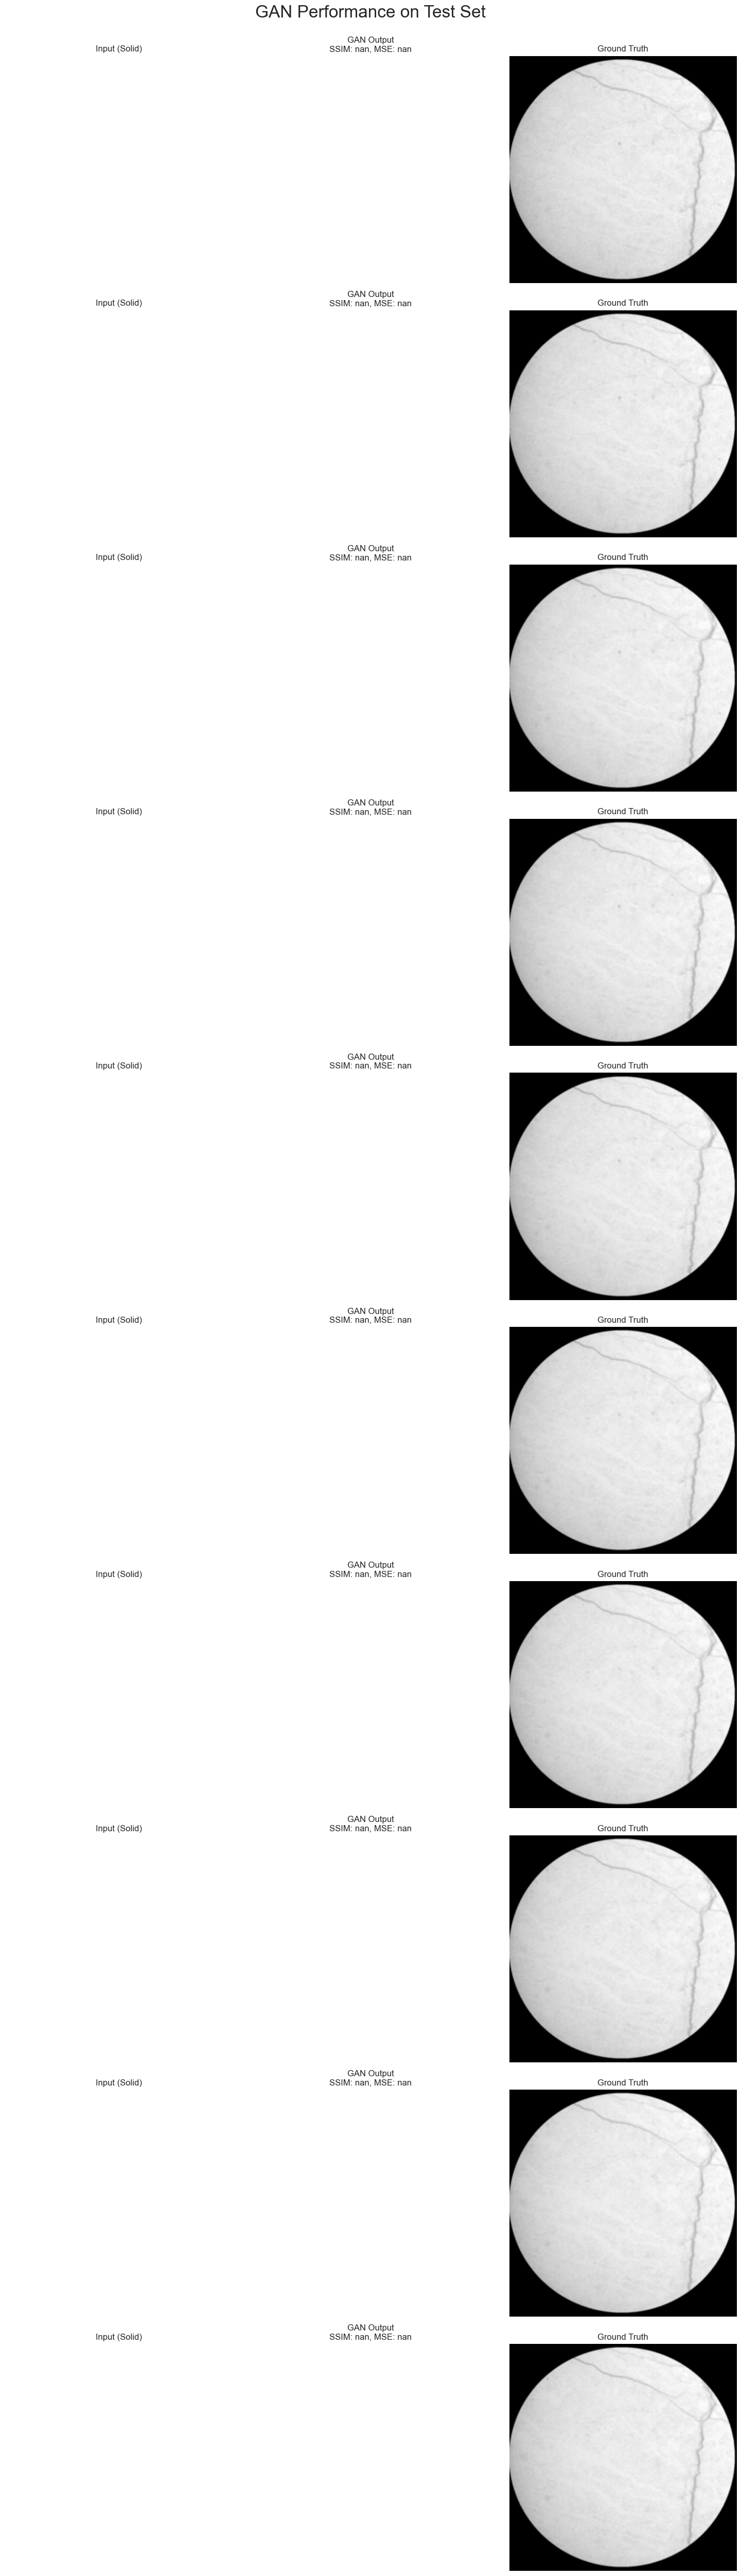


--- Quantitative Evaluation Report ---
Average Structural Similarity Index (SSIM) on test set: nan
Average Mean Squared Error (MSE) on test set: nan
Higher SSIM is better (max 1.0). Lower MSE is better.


In [12]:
# Cell 12: Final Evaluation and Report Generation

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# Set the generator to evaluation mode
gen.eval()

# Store metrics
ssim_scores, mse_scores = [], []

# --- Generate comparison plots for a sample from the test set ---
num_report_images = 10
fig, axes = plt.subplots(num_report_images, 3, figsize=(15, 5 * num_report_images))
fig.suptitle('GAN Performance on Test Set', fontsize=24, y=1.0)

with torch.no_grad():
    for i, (x, y_true) in enumerate(test_loader):
        if i >= num_report_images:
            break
        
        x, y_true = x.to(DEVICE), y_true.to(DEVICE)
        y_gan = gen(x)
        
        # Un-normalize images for viewing and metrics
        img_input = x[0, 0].cpu().numpy() * 0.5 + 0.5
        img_true = y_true[0, 0].cpu().numpy() * 0.5 + 0.5
        img_gan = y_gan[0, 0].cpu().numpy() * 0.5 + 0.5
        
        # Calculate metrics
        current_ssim = ssim(img_true, img_gan, data_range=1.0)
        current_mse = mean_squared_error(img_true, img_gan)
        ssim_scores.append(current_ssim)
        mse_scores.append(current_mse)
        
        # Plotting
        axes[i, 0].imshow(img_input, cmap='gray')
        axes[i, 0].set_title("Input (Solid)")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img_gan, cmap='gray')
        axes[i, 1].set_title(f"GAN Output\nSSIM: {current_ssim:.3f}, MSE: {current_mse:.4f}")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(img_true, cmap='gray')
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig("Final_Report_Comparison.png")
plt.show()

# --- Print average metrics for the report ---
avg_ssim = np.mean(ssim_scores)
avg_mse = np.mean(mse_scores)

print("\n--- Quantitative Evaluation Report ---")
print(f"Average Structural Similarity Index (SSIM) on test set: {avg_ssim:.4f}")
print(f"Average Mean Squared Error (MSE) on test set: {avg_mse:.4f}")
print("Higher SSIM is better (max 1.0). Lower MSE is better.")

In [12]:
# Cell 9: Data Preparation for GAN (Corrected for Data Integrity)

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms.functional import resize, to_tensor, normalize
import torch.nn as nn
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

# --- Hyperparameters and Setup ---
DEVICE = "cpu"
IMG_SIZE = 256
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
BETA1 = 0.5
L1_LAMBDA = 100

print(f"Using device: {DEVICE}")

# --- STABILITY FIX 1: Robustly calculate the rock_value ---
rock_pixels = raw_images[segmented_images == 0]
if rock_pixels.size > 0:
    rock_value = np.median(rock_pixels)
else:
    # This is a fallback in case a mask has no rock pixels.
    rock_value = np.median(raw_images) 
    print("Warning: Found a slice with no rock pixels in the mask. Using global median as a fallback.")

print(f"Calculated rock fill value: {rock_value}")

# --- Create Solid Rock Images (Inputs) ---
solid_rock_images = np.where(segmented_images > 0, rock_value, raw_images)

# --- Scale both datasets to float32 in [0, 1] ---
solid_rock_images_scaled = solid_rock_images.astype(np.float32) / 65535.0
raw_images_scaled = raw_images.astype(np.float32) / 65535.0

# --- STABILITY FIX 2: Final safeguard to remove any possible NaNs ---
# This will replace any NaN with 0.0 and any infinity with large finite numbers.
solid_rock_images_scaled = np.nan_to_num(solid_rock_images_scaled)
raw_images_scaled = np.nan_to_num(raw_images_scaled)


# --- Preprocess and Create Tensors ---
def preprocess_stack(stack_scaled):
    processed_tensors = []
    for img in tqdm(stack_scaled, desc="Preprocessing images"):
        img_tensor = to_tensor(img)
        img_resized = resize(img_tensor, [IMG_SIZE, IMG_SIZE])
        img_normalized = normalize(img_resized, [0.5], [0.5])
        processed_tensors.append(img_normalized)
    return torch.stack(processed_tensors)

input_tensor = preprocess_stack(solid_rock_images_scaled)
target_tensor = preprocess_stack(raw_images_scaled)

# --- Create PyTorch DataLoader ---
train_dataset = TensorDataset(input_tensor[100:], target_tensor[100:])
test_dataset = TensorDataset(input_tensor[:100], target_tensor[:100])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"\nData prepared and cleaned successfully!")
print(f"Input tensor contains NaNs: {torch.isnan(input_tensor).any()}")
print(f"Target tensor contains NaNs: {torch.isnan(target_tensor).any()}")

Using device: cpu
Calculated rock fill value: 35029.0


Preprocessing images:   0%|          | 0/887 [00:00<?, ?it/s]

Preprocessing images:   0%|          | 0/887 [00:00<?, ?it/s]


Data prepared and cleaned successfully!
Input tensor contains NaNs: False
Target tensor contains NaNs: False


In [13]:
# Cell 10: Model Architecture (Corrected with InstanceNorm2d)

# --- STABILITY FIX: Using InstanceNorm2d instead of BatchNorm2d ---
class UNetBlock(nn.Module):
    def __init__(self, in_c, out_c, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False, padding_mode="reflect") if down
            else nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
            # Switched to InstanceNorm2d
            nn.InstanceNorm2d(out_c),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=1, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = UNetBlock(features, features * 2, down=True, act="leaky")
        self.down2 = UNetBlock(features * 2, features * 4, down=True, act="leaky")
        self.down3 = UNetBlock(features * 4, features * 8, down=True, act="leaky")
        self.down4 = UNetBlock(features * 8, features * 8, down=True, act="leaky")
        self.down5 = UNetBlock(features * 8, features * 8, down=True, act="leaky")
        self.down6 = UNetBlock(features * 8, features * 8, down=True, act="leaky")
        self.bottleneck = nn.Sequential(nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU())

        self.up1 = UNetBlock(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = UNetBlock(features * 16, features * 8, down=False, act="relu", use_dropout=True)
        self.up3 = UNetBlock(features * 16, features * 8, down=False, act="relu", use_dropout=True)
        self.up4 = UNetBlock(features * 16, features * 4, down=False, act="relu")
        self.up5 = UNetBlock(features * 12, features * 2, down=False, act="relu")
        self.up6 = UNetBlock(features * 6, features, down=False, act="relu")
        self.up7 = UNetBlock(features * 3, features, down=False, act="relu")
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

# --- PatchGAN Discriminator ---
class Discriminator(nn.Module):
    def __init__(self, in_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels * 2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, feature, 4, stride=1 if feature == features[-1] else 2, padding=1, bias=False, padding_mode="reflect"),
                    # Switched to InstanceNorm2d
                    nn.InstanceNorm2d(feature),
                    nn.LeakyReLU(0.2),
                )
            )
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

print("Models defined with stable InstanceNorm2d layers.")

Models defined with stable InstanceNorm2d layers.


In [15]:
# Cell 11a: Generator Pre-training (Warm-up)

print("--- Starting Generator Warm-up ---")

gen = Generator().to(DEVICE)
disc = Discriminator().to(DEVICE)

# Use a safe learning rate for warm-up
gen_warmup_optim = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
L1 = nn.L1Loss()
WARMUP_EPOCHS1 = 4

gen.train()
for epoch in range(WARMUP_EPOCHS1):
    loop = tqdm(train_loader, leave=True, desc=f"Warm-up Epoch [{epoch+1}/{WARMUP_EPOCHS1}]")
    for idx, (x, y) in enumerate(loop):
        # Data integrity check
        assert not torch.isnan(x).any(), "NaN found in input data x"
        assert not torch.isnan(y).any(), "NaN found in target data y"
        
        x, y = x.to(DEVICE), y.to(DEVICE)
        y_fake = gen(x)
        loss = L1(y_fake, y)
        
        gen_warmup_optim.zero_grad()
        loss.backward()
        gen_warmup_optim.step()
        loop.set_postfix(L1_Loss=loss.item())

print("\n--- Generator Warm-up Finished. ---")

--- Starting Generator Warm-up ---


Warm-up Epoch [1/4]:   0%|          | 0/197 [00:00<?, ?it/s]

Warm-up Epoch [2/4]:   0%|          | 0/197 [00:00<?, ?it/s]

Warm-up Epoch [3/4]:   0%|          | 0/197 [00:00<?, ?it/s]

Warm-up Epoch [4/4]:   0%|          | 0/197 [00:00<?, ?it/s]


--- Generator Warm-up Finished. ---



--- Starting Full Adversarial Training ---


GAN Epoch [1/8]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [2/8]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [3/8]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [4/8]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [5/8]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [6/8]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [7/8]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [8/8]:   0%|          | 0/197 [00:00<?, ?it/s]


--- Generating Final Report ---


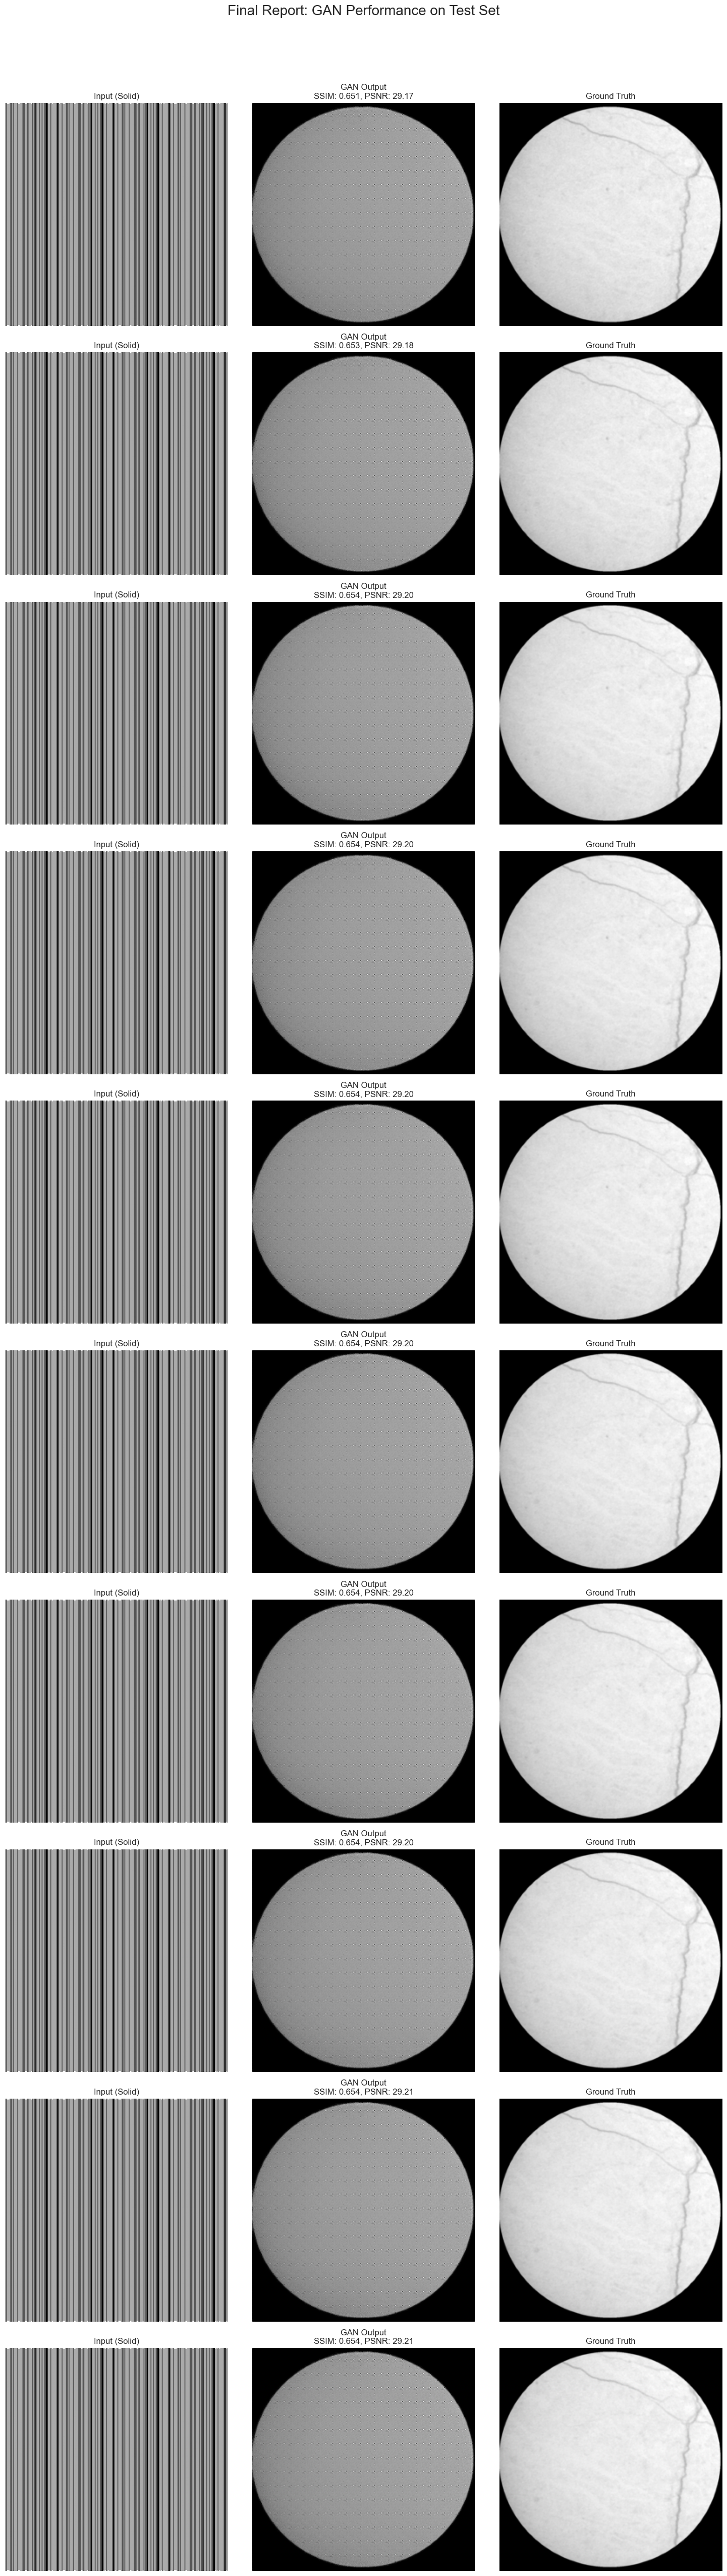


Average SSIM on 10 test images: 0.6536
Average PSNR on 10 test images: 29.1982

Training and evaluation finished successfully.


In [18]:
# Cell 11b & 12: Main Training and Final Evaluation

print("\n--- Starting Full Adversarial Training ---")

# We use the same LEARNING_RATE defined in the first cell (1e-4)
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
BCE = nn.BCEWithLogitsLoss()
NUM_EPOCHS = 8

# Create directories
os.makedirs("gan_outputs", exist_ok=True)
os.makedirs("final_report", exist_ok=True)

for epoch in range(NUM_EPOCHS):
    loop = tqdm(train_loader, leave=True, desc=f"GAN Epoch [{epoch+1}/{NUM_EPOCHS}]")
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)

        # Train Discriminator
        y_fake = gen(x)
        D_real = disc(x, y)
        D_fake = disc(x, y_fake.detach())
        D_loss = (BCE(D_real, torch.ones_like(D_real)) + BCE(D_fake, torch.zeros_like(D_fake))) / 2
        disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        # Train Generator
        D_fake = disc(x, y_fake)
        G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))
        L1_loss = L1(y_fake, y) * L1_LAMBDA
        G_loss = G_fake_loss + L1_loss
        gen.zero_grad()
        G_loss.backward()
        opt_gen.step()
        loop.set_postfix(D_loss=D_loss.item(), G_loss=G_loss.item())
        
# --- Final Evaluation and Report ---
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

print("\n--- Generating Final Report ---")
gen.eval()
ssim_scores, psnr_scores = [], []
num_report_images = 10 

fig, axes = plt.subplots(num_report_images, 3, figsize=(15, 5 * num_report_images))
fig.suptitle('Final Report: GAN Performance on Test Set', fontsize=20, y=1.02)

with torch.no_grad():
    for i, (x, y_true) in enumerate(test_loader):
        if i >= num_report_images: break
        x, y_true = x.to(DEVICE), y_true.to(DEVICE)
        y_gan = gen(x)
        
        img_true = (y_true[0, 0].cpu().numpy() * 0.5 + 0.5)
        img_gan = (y_gan[0, 0].cpu().numpy() * 0.5 + 0.5)
        
        s = ssim(img_true, img_gan, data_range=1.0)
        p = psnr(img_true, img_gan, data_range=1.0)
        ssim_scores.append(s)
        psnr_scores.append(p)
        
        axes[i, 0].imshow(x[0, 0].cpu().numpy() * 0.5 + 0.5, cmap='gray'); axes[i, 0].set_title("Input (Solid)"); axes[i, 0].axis('off')
        axes[i, 1].imshow(img_gan, cmap='gray'); axes[i, 1].set_title(f"GAN Output\nSSIM: {s:.3f}, PSNR: {p:.2f}"); axes[i, 1].axis('off')
        axes[i, 2].imshow(img_true, cmap='gray'); axes[i, 2].set_title("Ground Truth"); axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig("final_report/comparison_grid.png")
plt.show()

print(f"\nAverage SSIM on {num_report_images} test images: {np.mean(ssim_scores):.4f}")
print(f"Average PSNR on {num_report_images} test images: {np.mean(psnr_scores):.4f}")
print("\nTraining and evaluation finished successfully.")